In [7]:
import pandas as pd
df=pd.read_csv('../data/final_data.csv')
df.columns

Index(['Date', 'Hour', 'DEgen', 'DEload', 'DKgen', 'DKload', 'HUgen', 'HUload',
       'ITgen', 'ITload', 'NEgen', 'NEload', 'POgen', 'POload', 'SEgen',
       'SEload', 'SPgen', 'SPload', 'HU_surplus', 'IT_surplus', 'PO_surplus',
       'SP_surplus', 'DE_surplus', 'DK_surplus', 'SE_surplus', 'NE_surplus',
       'label', 'spring', 'summer', 'winter', 'day_of_week', 'is_weekend'],
      dtype='object')

In [10]:
#X--> We create an array with 8 countries and 8759 hours of 7 features.
# y--> The surplus will be our target, so we created another array of 8 countries and 8769 hours using the surplus column
import numpy as np

countries=['HU','IT','PO','SP','DE','DK','SE','NE']

def get_series_country(country):
    X = np.zeros((df.shape[0],7))
    y = np.zeros((df.shape[0]))
    X[:,0] = df[country+'gen'].values
    X[:,1] = df[country+'load'].values
    X[:,2] = df['Hour'].values
    X[:,3] = df['is_weekend'].values
    X[:,4] = df['summer'].values
    X[:,5] = df['spring'].values
    X[:,6] = df['winter'].values
    y=df[country+'_surplus'].values
    return X, y

In [16]:
def eighty_twenty_split(X,y):
    split = int(X.shape[0]*.8)
    X_train = X[: split]
    X_test = X[split :]
    y_train = y[: split]
    y_test = y[split :]
    return X_train, y_train, X_test, y_test

input_len = 168 # The amount of hours we want to use as input data

def create_sequences(X, y, input_len):
    sequences =  np.zeros((X.shape[0]-input_len, input_len, X.shape[1]))
    target_values = np.zeros((y.shape[0]-input_len))
    for i in range(X.shape[0] - input_len):
        sequences[i, : , :] = X[i : i+input_len, :]

    sequences_train=sequences[:-1, :, :]
    target_values=y[input_len+1:]
    return sequences_train, target_values





In [19]:
# normalize data

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_train_test_series(sequences_train, target_values_train, sequences_test, target_values_test, return_target_scaler):
    # Min-Max Scaler initialization
    scaler_target_values = MinMaxScaler()

    # Normalizing the surplus
    target_values_train_scaled = scaler_target_values.fit_transform(target_values_train.reshape(-1, 1)).flatten()
    target_values_test_scaled = scaler_target_values.transform(target_values_test.reshape(-1, 1)).flatten()



    # Normalizing features
    scaler_features = MinMaxScaler()
    sequences_train_scaled = sequences_train
    sequences_test_scaled = sequences_test
    for feature in range(sequences_train.shape[-1]):
        sequences_train_scaled[:, :, feature] = scaler_features.fit_transform(sequences_train[:, :, feature])
        sequences_test_scaled[:, :, feature] = scaler_features.transform(sequences_test[:, :, feature])

    if return_target_scaler==True:
        return sequences_train_scaled, sequences_test_scaled, target_values_train_scaled, target_values_test_scaled, scaler_target_values
    else:
         return sequences_train_scaled, sequences_test_scaled, target_values_train_scaled, target_values_test_scaled

Train sequences and targets
(6839,)
(6839, 168, 7)
Test sequences and targets
(1583,)
(1583, 168, 7)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 16)          1536      
                                                                 
 lstm_7 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_8 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5777 (22.57 KB)
Trainable params: 5777 (22.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
214/214 [==============================] 

c:\Users\afred\miniconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


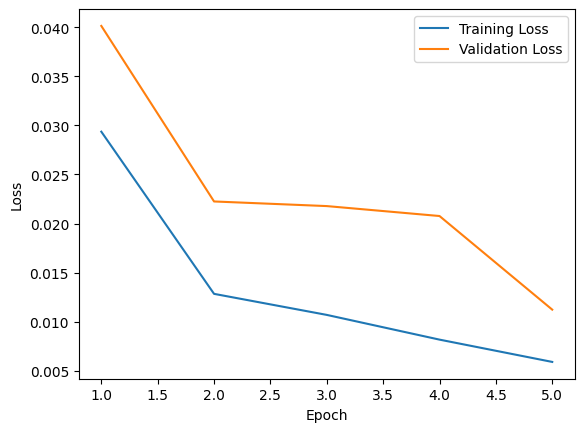

In [23]:
X,y = get_series_country('HU')
X_train, y_train, X_test, y_test = eighty_twenty_split(X , y)

input_len = 168
sequences_train, target_values_train = create_sequences(X_train, y_train, input_len)
sequences_test, target_values_test = create_sequences(X_test, y_test, input_len)

sequences_train_scaled, sequences_test_scaled, target_values_train_scaled, target_values_test_scaled, scaler_target_values = scale_train_test_series(sequences_train, target_values_train, sequences_test, target_values_test, return_target_scaler = True)

print('Train sequences and targets')
print(target_values_train_scaled.shape)
print(sequences_train_scaled.shape)
print('Test sequences and targets')
print(target_values_test_scaled.shape)
print(sequences_test_scaled.shape)


#shuffle training data
indices = np.arange(target_values_train_scaled.shape[0])
np.random.shuffle(indices)
sequences_train_scaled = sequences_train_scaled[indices]
target_values_train_scaled = target_values_train_scaled[indices]


#create a model
import tensorflow as tf
model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(16, return_sequences=True, input_shape=[None, 7]),
tf.keras.layers.LSTM(16, return_sequences=True),
tf.keras.layers.LSTM(16),
tf.keras.layers.Dense(1)
])
model.summary()

#fit the model
model.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model.fit(sequences_train_scaled, target_values_train_scaled, epochs=5, validation_data=(sequences_test_scaled,target_values_test_scaled))

#save the model 
save_path='../models/'+'model_HU.h5'
model.save(save_path)

#plotting the loss curve
import matplotlib.pyplot as plt
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 16)          1536      
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5777 (22.57 KB)
Trainable params: 5777 (22.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
X.shape

(8760, 7)

In [106]:
model.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history=model.fit(sequences_train_scaled, target_values_scaled, epochs=20, validation_data=(sequences_test_scaled,))


Epoch 1/20


214/214 [==============================] - 37s 130ms/step - loss: 0.0216 - mae: 0.1145
Epoch 2/20
214/214 [==============================] - 29s 135ms/step - loss: 0.0084 - mae: 0.0709
Epoch 3/20
214/214 [==============================] - 34s 158ms/step - loss: 0.0050 - mae: 0.0534
Epoch 4/20
214/214 [==============================] - 32s 149ms/step - loss: 0.0041 - mae: 0.0481
Epoch 5/20
214/214 [==============================] - 28s 132ms/step - loss: 0.0037 - mae: 0.0459
Epoch 6/20
214/214 [==============================] - 28s 129ms/step - loss: 0.0034 - mae: 0.0439
Epoch 7/20
214/214 [==============================] - 28s 129ms/step - loss: 0.0034 - mae: 0.0442
Epoch 8/20
214/214 [==============================] - 28s 129ms/step - loss: 0.0030 - mae: 0.0409
Epoch 9/20
214/214 [==============================] - 28s 130ms/step - loss: 0.0029 - mae: 0.0399
Epoch 10/20
214/214 [==============================] - 27s 128ms/step - loss: 0.0027 - mae: 0.0389
Epoch 11/20
214/

In [112]:


# Evaluate the model
test_loss = model.evaluate(sequences_test_scaled, target_values_test_scaled)

print("Test Loss (MSE):", test_loss)

50/50 [==============================] - 3s 49ms/step


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

NameError: name 'title' is not defined

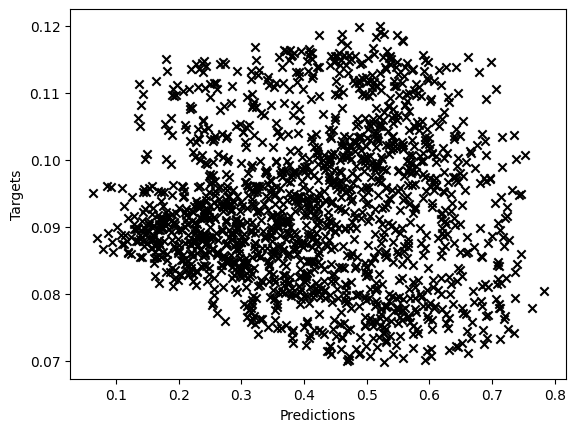

In [111]:
preds = model.predict(sequences_test_scaled)
plt.scatter(target_values_test_scaled,preds, color='black',marker='x' ,label='Data points')
#x=[a,b]
#y=[a,b]
#plt.plot(x, y, color='red' ,label='x=y', linewidth=3.0)


plt.xlabel('Predictions')
plt.ylabel('Targets')

plt.title(title)
#plt.legend(loc='upper right')
plt.rcParams['font.size'] = 20
plt.show()

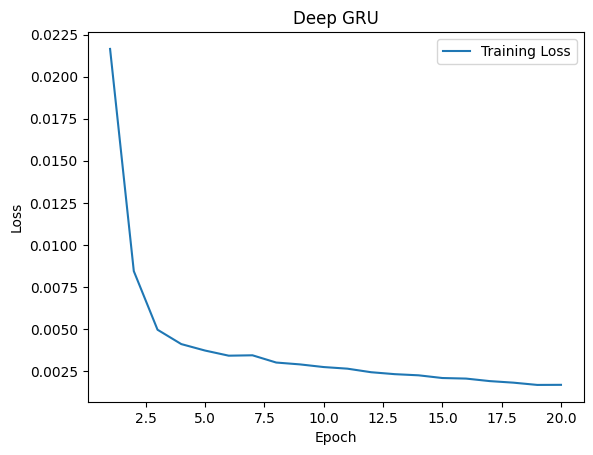

In [113]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
#val_loss = history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.plot(epochs, train_loss, label='Training Loss')
#plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

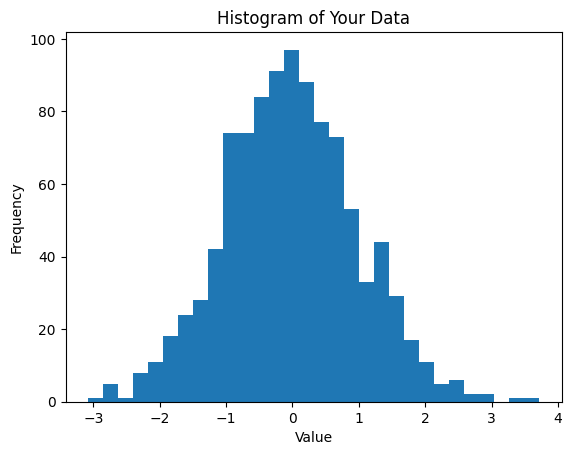

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: replace 'your_array' with your actual array
target_values_scaled = np.random.randn(1000)  # Example: A random array with 1000 elements

# Creating the histogram
plt.hist(target_values_scaled, bins=30)  # You can adjust the number of bins as needed
plt.title('Histogram of Your Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()
